In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from IPython.display import HTML, Image
import statsmodels.api as sm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, log_loss
from sklearn.linear_model import Ridge


In [2]:
df = pd.read_csv('basics500.csv')

In [3]:
df.shape

(4920, 7)

In [4]:
df = df.dropna()

In [5]:
df.shape

(4397, 7)

In [6]:
df.columns

Index(['Unnamed: 0', 'earned', 'headline', 'hours', 'jobs', 'rate', 'skills'], dtype='object')

In [7]:
df = df.drop(['Unnamed: 0', 'earned'], axis=1)

In [8]:
df = df.drop_duplicates()

In [9]:
df.shape

(3254, 5)

In [10]:
df.describe()

,headline,hours,jobs,rate,skills
count,3254,3254,3254,3254,3254
unique,2970,1671,309,277,3217
top,Graphic Designer,219,1,$25.00,['Adobe Flash']
freq,31,13,163,276,7


In [11]:
df['rate'] = df['rate'].map(lambda string: float(''.join([c for c in string if c.isdigit()]))/100)

In [12]:
df['hours'] = df['hours'].map(lambda string: int(''.join([c for c in string if c.isdigit()])))

In [13]:
df['jobs'] = df['jobs'].map(lambda string: int(''.join([c for c in string if c.isdigit()])))

In [14]:
df['skills'] = df['skills'].map(lambda string: string.replace('[', ""))

In [15]:
df['skills'] = df['skills'].map(lambda string: string.replace(']', ""))

In [16]:
df['skills'] = df['skills'].map(lambda string: string.replace("'", ""))

In [17]:
df['skills'] = df['skills'].map(lambda string: string.replace('"', ''))

In [18]:
df['skills'] = df['skills'].map(lambda string: string.split(", "))

In [19]:
df.skills.iloc[0]

['Copywriting',
 'Research Papers',
 'Article Writing',
 'Blog Writing',
 'Content Writing',
 'Comic Writing']

In [20]:
new_df = df['skills'].str.join('|').str.get_dummies()

In [21]:
sum(new_df.iloc[0, :])

6

In [22]:
new_df.head()

,.NET Compact Framework,.NET Framework,.NET Remoting,1ShoppingCart,2D Animation,2D Design,3D Animation,3D Design,3D Modeling,3D Printing,...,insightly,j2 Global Campaigner,jQuery,jQuery UI,memoQ,mobi,phpMyAdmin,soapUI,vCita,webERP
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
ridgeReg = Ridge(alpha=0.05, normalize=True)

In [39]:
ridgeReg.fit(new_df, y)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [42]:
cv = 4
m = cross_val_score(Ridge(alpha=0.05, normalize=True), new_df, y, scoring = 'r2', cv = cv)

In [43]:
m

array([-0.21289071, -0.40062026, -0.75721555, -0.05734177])

In [24]:
lista = list(new_df.columns)

In [25]:
sorted_list = sorted(lista, key=lambda s: s.casefold())

In [26]:
sorted_list[-10:]

['Zabbix',
 'Zapier',
 'Zen Cart',
 'Zend Framework',
 'Zendesk',
 'Zoho Creator',
 'Zoho CRM',
 'Zoom Video Conferencing',
 'Zopim',
 'Zurb Foundation']

In [27]:
len(sorted_list)

1981

In [28]:
y = df.rate
y = y.values

Text(0.5,1,'Rates')

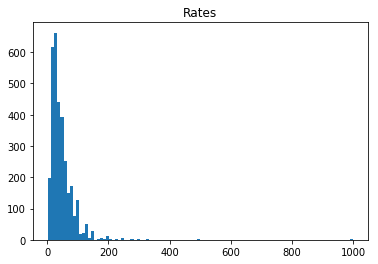

In [29]:
plt.hist(y, bins = 100)
plt.title('Rates')

In [35]:
X = df.drop(['rate', 'headline'], axis = 1)

In [36]:
X.skills = X.skills.map(lambda li: len(li))

In [37]:
X.head()

,hours,jobs,skills
0,4376,27,6
1,1605,21,10
2,2711,86,8
3,2805,37,10
4,3526,23,10


In [ ]:
for c in list(X.columns):
    print(type(X[c].iloc[0]))

In [ ]:
names = X.columns

In [ ]:
new_names = new_df.columns

In [ ]:
X = X.values
X = X.astype(float)

In [ ]:
new_X = new_df.values
new_X = new_X.astype(float)

In [ ]:
cv = 4
m = cross_val_score(LinearRegression(), new_X, y=y, cv = cv)

In [ ]:
m

In [ ]:
LR = LinearRegression()

In [ ]:
model = LR.fit(new_X, y)

In [ ]:
model.score(new_X,y)

In [ ]:
y_pred = model.predict(new_X)

In [ ]:
min(model.coef_)

In [ ]:
model.intercept_

In [ ]:
d = {'names' : new_names, 'coefs' : model.coef_}

In [ ]:
FI = pd.DataFrame(d)

In [ ]:
sorted_FI = FI.sort_values(by=['coefs'])

In [ ]:
sorted_FI

In [ ]:
np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
r2_score(y, y_pred)

In [ ]:
plt.hist(X[:,0], bins = 20)
plt.title('Hours Worked')

In [ ]:
plt.hist(X[:,1], bins = 20)
plt.title('Jobs Done')

In [ ]:
plt.hist(X[:,2], bins = 20)
plt.title('Number of Skills')

In [ ]:
XT = X.T

In [ ]:
new_XT = new_X.T

In [ ]:
prod = XT @ X

In [ ]:
new_prod = new_XT @ new_X

In [ ]:
inv = np.linalg.inv(prod)

In [ ]:
new_inv = np.linalg.inv(new_prod)

In [ ]:
triple_X = inv @ XT

In [ ]:
theta = triple_X @ y

In [ ]:
preds = [theta @ X[i,:] for i in range(len(y))]

In [ ]:
err = [(y[i] - preds[i])for i in range(len(y))]

In [ ]:
theta2 = theta*1.1

In [ ]:
preds2 = [theta2 @ X[i,:] for i in range(len(y))]
err2 = [(y[i] - preds2[i]) for i in range(len(y))]

In [ ]:
RMSE = (sum([e**2 for e in err])/len(y))**0.5
RMSE2 = (sum([e**2 for e in err2])/len(y))**0.5

In [ ]:
RMSE, RMSE2

In [ ]:
RMSE2 - RMSE

In [ ]:
results = sm.OLS(y, X).fit()

In [ ]:
print(list(zip(list(names),list(theta/100))))

In [ ]:
print(results.summary())